# Graph Visualizations

In [38]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)
print(parent)

c:\Users\aless\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis


## Data

## Prediction

In [39]:
directory = os.path.join("data", "raw", "unzipped", "BACH_TEST", "ICIAR2018_BACH_Challenge_TestDataset", "Photos")
file_name = "test0.tif"

img_loc = os.path.join(parent,directory, file_name)

In [40]:

import os
from src.model.architectures.graph_construction.hover_net import HoVerNet
from src.model.architectures.cancer_prediction.cell_unet_ae import UNET_AE
from src.model.architectures.cancer_prediction.pred_gnn import PredGNN
from PIL import Image
from torchvision.transforms import ToTensor
from src.transforms.graph_construction.hovernet_post_processing import instance_mask_prediction_hovernet, cut_img_from_tile
from src.transforms.graph_construction.graph_extractor import extract_graph, cell_to_voting_graph
from torch_geometric.transforms import Compose, KNNGraph, RandomTranslate, Distance
import torch
from torch_geometric.loader.dataloader import DataLoader
import matplotlib.backends.backend_pdf
from src.utilities.img_utilities import tensor_to_numpy
import matplotlib.pyplot as plt
from src.transforms.graph_construction.percolation import hollow
from numpy.ma import masked_where
import numpy as np
import torch
from torch import Tensor

with torch.no_grad():
    graph_trans = Compose([KNNGraph(6),  Distance(norm=False, cat=False)])

    gnn_voter_args = {"LAYERS": 10, "WIDTH": 8, "GLOBAL_POOL": "MEAN", "RADIUS_FUNCTION": "INVSQUARE", "POOL_RATIO": 1}

    hover_net_loc=os.path.join(parent,"model", "HoVerNet.ckpt")
    cell_predictor_loc=os.path.join(parent,"model", "CELL_PREDICTOR.ckpt")
    gnn_voter_loc=os.path.join(parent,"model", "GNN_VOTER.ckpt")


    hover_net = HoVerNet.load_from_checkpoint(hover_net_loc).eval().cpu()
    cell_predictor = UNET_AE.load_from_checkpoint(cell_predictor_loc).cpu()
    def cell_predict(X): return cell_predictor.forward_pred(X)
    gnn_voter = PredGNN.load_from_checkpoint(gnn_voter_loc, **gnn_voter_args).cpu()

    # Load the image
    image = ToTensor()(Image.open(img_loc))

    # Create Instance Mask for cells
    instance_mask = instance_mask_prediction_hovernet(hover_net, image).cpu().detach()
    image_cropped = cut_img_from_tile(image, 128)

    del hover_net
    del image
    torch.cuda.empty_cache()


#del gnn_voter



In [41]:
# Generate Cell Graph
cell_graph = extract_graph(image_cropped, instance_mask)
cell_graph.x.requires_grad_(True)
# Generate Voting Graph

voting_graph = cell_to_voting_graph(cell_graph, cell_predict)
voting_graph = graph_trans(voting_graph)

#del cell_predictor

# Make Final Prediction

prediction = gnn_voter(voting_graph.x, voting_graph.edge_index, voting_graph.edge_attr,
                        torch.zeros(voting_graph.x.shape[0]).long()).squeeze()

prediction[prediction.argmax()].backward()
print(cell_graph.x.grad)

tensor([[ 7.0119e-05, -4.8822e-05,  2.2482e-04,  ..., -1.6973e-05,
         -4.3678e-06,  2.8822e-05],
        [ 5.5121e-06,  8.2309e-09, -4.4628e-05,  ...,  7.2114e-06,
          3.9345e-05,  1.7227e-05],
        [ 2.6566e-05, -3.7240e-05, -1.1076e-05,  ..., -1.3042e-04,
         -5.0517e-05, -1.1615e-04],
        ...,
        [-1.6111e-05,  3.4277e-05, -5.4458e-05,  ...,  1.2698e-04,
         -3.1431e-04, -2.3469e-04],
        [ 3.8162e-05, -7.6361e-05,  5.9102e-05,  ...,  2.0777e-04,
         -1.8561e-04, -1.8331e-04],
        [ 5.9002e-05, -1.3264e-04,  1.3402e-04,  ...,  7.5211e-06,
         -8.0689e-06,  1.3471e-05]])


## Explanations

In [133]:
import torch
import matplotlib.pyplot as plt
from src.vizualizations.tensor_viz import plot_tensor_histogram

def plot_graph_crop_on_image(X,pos,image):
    img = torch.zeros_like(image)
    print(X.shape)
    print(img.shape)
    for i,(c,r) in enumerate(pos):
        r,c = r.int(),c.int()
        img[:,r-32:r+32,c-32:c+32] += X[i].max()
        #if i ==10:
         #   break
    #img = img.max(dim=0).values*20

    #plot_tensor_histogram(img, bins=10000)
    #plt.show()
    
    img = img.detach().cpu()
    plt.figure(figsize=(20,20))
    plt.imshow(tensor_to_numpy(img),cmap="gray")
     

tensor([[ 7.0119e-05, -4.8822e-05,  2.2482e-04,  ..., -1.6973e-05,
         -4.3678e-06,  2.8822e-05],
        [ 5.5121e-06,  8.2309e-09, -4.4628e-05,  ...,  7.2114e-06,
          3.9345e-05,  1.7227e-05],
        [ 2.6566e-05, -3.7240e-05, -1.1076e-05,  ..., -1.3042e-04,
         -5.0517e-05, -1.1615e-04],
        ...,
        [-1.6111e-05,  3.4277e-05, -5.4458e-05,  ...,  1.2698e-04,
         -3.1431e-04, -2.3469e-04],
        [ 3.8162e-05, -7.6361e-05,  5.9102e-05,  ...,  2.0777e-04,
         -1.8561e-04, -1.8331e-04],
        [ 5.9002e-05, -1.3264e-04,  1.3402e-04,  ...,  7.5211e-06,
         -8.0689e-06,  1.3471e-05]])
torch.Size([1064, 3, 64, 64])
torch.Size([3, 1408, 1920])


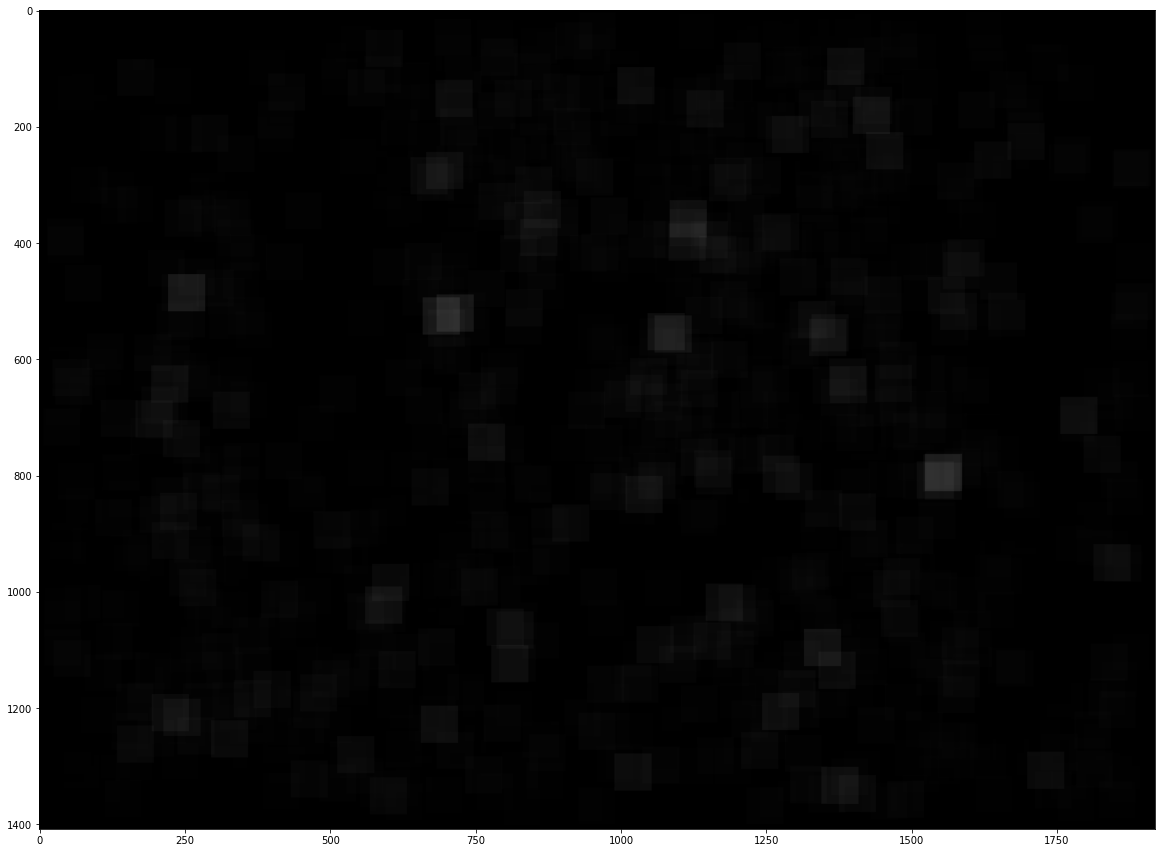

In [134]:
grad = cell_graph.x.grad.clone()
print(grad)
plot_graph_crop_on_image(grad.unflatten(1,(3,64,64)),cell_graph.pos,image_cropped)